In [167]:
import numpy as np
import matplotlib.pyplot as plt
from icecream import ic
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import LinearOperator

%matplotlib widget


In [168]:
def radial_fdm_laplacian(r_max, n, left_bc = 'neumann'):
    """Generate laplacian in 2d polar coordinates, radial part.
    
    Discretize [0, r_max] with n+2 points, and apply
    neumann conditions on r=0 and Dirichlet on r=r_max, 
    resulting in an nxn matrix for the inner grid points.
    
    Args:
        r_max (float): right endpoint
        n (int): number of inner grid points
        left_bc (str, optional): 'neumann' for neumann BC, else dirichlet.
    
    Returns:
        ndarray: Laplacian as CRS matrix
        r: radial grid with endpoints
        G: transition matrix from inner to global grid
    
    """
    r = np.linspace(0, r_max, n+2)
    L = np.zeros((n,n+2))
    h = r[1]-r[0]
    
    for i in range(1,n+1):
        L[i-1,i+1] = (r[i]+h/2)/r[i]
        L[i-1,i-1] = (r[i]-h/2)/r[i]
        L[i-1,i] = -2 #-(r[i] + h/2)/r[i] - (r[i] - h/2)/r[i]
    
    G = np.zeros((n+2,n))
    G[1:-1,:] = np.eye(n)
    if left_bc == 'neumann':
        G[0,0] = 4/3
        G[0,1] = -1/3
    else:
        pass
    
    L1 = L @ G / h**2
    return L1, r, G

In [169]:
m = 0

L, r0, G = radial_fdm_laplacian(10, 100, left_bc = 'neumann' if m == 0 else 'dirichlet')
r = r0[1:-1]
H = -0.5*L + np.diag(r**2/2 + .5*m**2/r**2)



In [170]:
E, U = np.linalg.eig(H)
i = np.argsort(E)
E = E[i]
U = U[:,i]
E

array([  0.99879998,   2.99399285,   4.98436097,   6.96988313,
         8.95053786,  10.92630349,  12.8971581 ,  14.86307956,
        16.82404552,  18.7800334 ,  20.73102042,  22.67698356,
        24.61789958,  26.55374499,  28.48449609,  30.41012893,
        32.33061937,  34.24594377,  36.1560849 ,  38.06107444,
        39.96122985,  41.85814449,  43.75754103,  45.6739174 ,
        47.63180193,  49.65753335,  51.76812425,  53.96866029,
        56.25679956,  58.62736807,  61.07469159,  63.59339312,
        66.17855005,  68.82565008,  71.53050531,  74.28917258,
        77.0978898 ,  79.95302794,  82.85105523,  85.78851069,
        88.76198456,  91.76810389,  94.8035218 ,  97.86490973,
       100.9489517 , 104.05234033, 107.17177404, 110.30395528,
       113.44558945, 116.59338446, 119.74405069, 122.89430127,
       126.04085269, 129.18042539, 132.30974464, 135.42554127,
       138.52455245, 141.60352232, 144.65920247, 147.68835213,
       150.68773802, 153.65413379, 156.58431891, 159.47

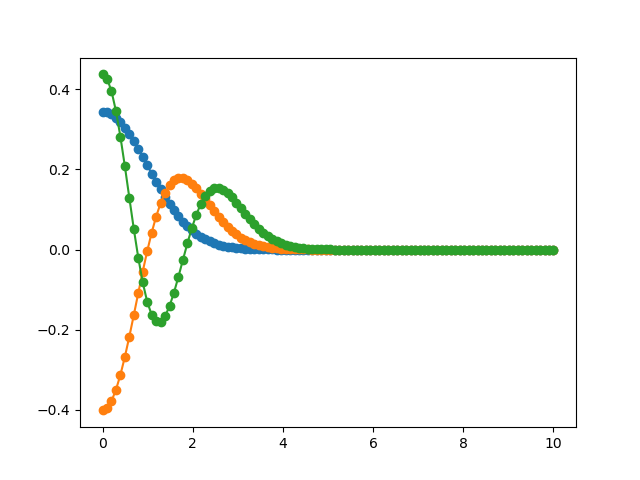

In [171]:
plt.figure()
plt.plot(r0,G@U[:,:3], 'o-')
plt.show()

In [172]:
class polar_fdm_2d:
    """Class for 2d polar FDM SE solver.
    
    Attributes:
        r_max (float): right endpoint
        n_r (int): number of inner grid points
        m_max (int): maximum angular momentum
        L_neumann (ndarray): radial laplacian with Neumann BC
        L_0 (ndarray): radial laplacian with Dirichlet BC
        r0 (ndarray): radial grid with endpoints
        r_inner (ndarray): inner radial grid points
        G_neumann (ndarray): transition matrix from inner to global grid with Neumann BC
        G_0 (ndarray): transition matrix from inner to global grid with Dirichlet BC
        T_m (list of ndarray): Kinetic energy for each |m|
        V_m (list of ndarray): list of potential matrices V(r) for each m.
        V_m_max (int): number of potential matrices
    """
    
    def __init__(self, r_max, n_r, m_max):
        """Initialize the polar FDM grid.
        
        Args:
            r_max (float): right endpoint
            n_r (int): number of inner grid points
            m_max (int): maximum angular momentum
        """
        self.r_max = r_max
        self.n_r = n_r
        self.m_max = m_max

        # Set up radial laplacian for Neumann and Dirichlet BC
        self.L_neumann, self.r0, self.G_neumann = radial_fdm_laplacian(r_max, n_r, left_bc = 'neumann')
        self.L_neumann = csr_matrix(self.L_neumann)
        self.L_0, _, self.G_0 = radial_fdm_laplacian(r_max, n_r, left_bc = 'dirichlet')
        self.L_0 = csr_matrix(self.L_0)
        self.r_inner = self.r0[1:-1]        
        
        # Set up Kinetic energy for each |m|
        self.T_m = []
        for m in range(m_max+1):
            if m == 0:
                self.T_m.append( -0.5*self.L_neumann  )
            else:
                self.T_m.append( -0.5*self.L_0 + np.diag(.5*m**2/self.r_inner**2) )
                
        
        # Set wavefunction shape
        self.shape = (n_r, 2*m_max + 1)
        # Set number of degrees of freedom
        self.n_dof = np.prod(self.shape)

            

    def set_potential(self, V_m):
        """ Set the scalar potential.
        
        
        Args:
            V_m (list of ndarray): list of potential matrices V(r) for each m.
        """
        self.V_m = V_m
        self.V_m_max = (len(V_m) - 1)//2
        ic(self.V_m_max)


    def apply_hamiltonian(self, psi):
        """Apply the Hamiltonian to a wavefunction.
        """
        
        
        assert(psi.shape == self.shape)
        result = np.zeros(self.shape, dtype=np.complex128)
        
        for m in range(-self.m_max, self.m_max+1):
            m_index = m + self.m_max
            #ic(m, m_index)
            result[:,m_index] = self.T_m[abs(m)] @ psi[:,m_index] 
            for m2 in range(-self.V_m_max, self.V_m_max+1):
                m2_index = self.V_m_max + m2
                m3 = m - m2
                if m3 >= -self.m_max and m3 <= self.m_max:
                    m3_index = m3 + self.m_max
                    #ic(m_index, m2_index, m3_index)
                    result[:,m_index] += self.V_m[m2_index] * psi[:,m3_index]
        
        return result
    
    def get_dense_matrix(self):
        """Compute dense matrix representation of H."""
        def apply_hamiltonian(psi_vec):
            return self.apply_hamiltonian(psi_vec.reshape(self.shape)).flatten()

        H = LinearOperator((self.n_dof, self.n_dof), matvec=apply_hamiltonian, dtype=np.complex128)
        
        H_mat = np.zeros((self.n_dof, self.n_dof), dtype=np.complex128)
        
        ic(self.n_dof)
        for i in range(self.n_dof):
            e = np.zeros(self.n_dof)
            e[i] = 1
            H_mat[:,i] = apply_hamiltonian(e)
            
        return H_mat

        
        
    

ic

| self.V_m_max: 1
ic| self.n_dof: 2100


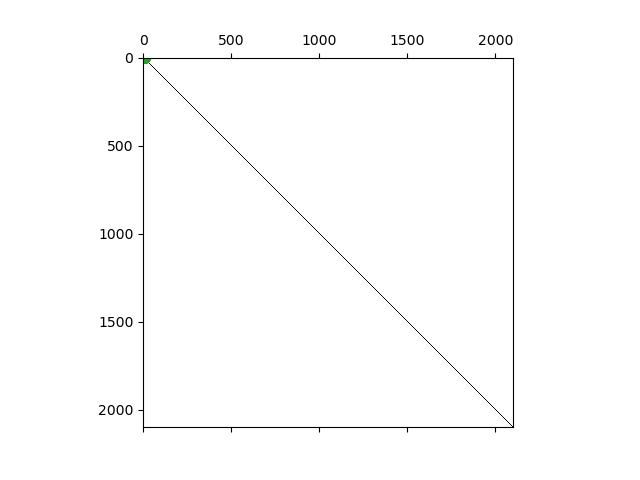

In [173]:
solver = polar_fdm_2d(r_max = 10, n_r = 100, m_max = 10)

# Set up potential V(x, y) = alpha * x = alpha * r * cos(theta)  + 0.5*r**2
# = alpha * r * 0.5 * (exp(i*theta) + exp(-i*theta)) + 0.5*r**2

# For all alpha, this is just a shifted harmonic oscillator
# and should produce evenly spaced energy levels with correct degeneracies 1, 2, 3. ...
alpha = 0.56
V_m = []
V_m.append(0.5*alpha*solver.r_inner)
V_m.append(0.5*solver.r_inner**2)
V_m.append(0.5*alpha*solver.r_inner)
solver.set_potential(V_m)

# Compute dense matrix version of Hamiltonian.
H_mat = solver.get_dense_matrix()

# Plot sparsity pattern. Zoom in for details.
plt.figure
plt.spy(H_mat)
plt.show()


In [158]:
# Compute the first eigenvalues and the differences between them.
# For a HO this should give approximately, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1.
np.diff(np.sort(np.linalg.eig(H_mat)[0])[:11]) 

array([9.99033608e-01+1.30638161e-18j, 8.02306007e-04-8.77185946e-20j,
       9.96892265e-01+9.56088011e-20j, 2.48752393e-03-1.01744703e-18j,
       1.49829942e-04+2.80636121e-21j, 9.93657067e-01+5.65181703e-16j,
       2.85530868e-03-6.79211029e-17j, 3.39228612e-03-2.90485801e-15j,
       1.17625488e-05+5.12946168e-16j, 9.90733893e-01+8.96086567e-16j])

In [159]:
from scipy.sparse.linalg import cg, LinearOperator, eigs

def apply_hamiltonian(psi_vec):
    return solver.apply_hamiltonian(psi_vec.reshape(solver.shape)).flatten()

H = LinearOperator((solver.n_dof, solver.n_dof), matvec=apply_hamiltonian, dtype=np.complex128)

psi_vec = np.random.rand(solver.n_dof)

from time import time
start = time()
# psi_vec = H @ psi_vec


result = eigs(H, k=10, which='SR')
ic(time() - start)


KeyboardInterrupt: 

In [118]:
np.diff(result[0])

array([1.99519287+2.96263399e-14j, 1.99036812-1.90093082e-14j,
       1.98552215+5.07231050e-15j, 1.98065473-1.82708755e-15j,
       1.97576563-2.00986185e-15j, 1.97085461+1.14619244e-15j,
       1.96592146+3.24574424e-15j, 1.96096596-9.88483542e-15j,
       1.95598789-1.85318485e-15j])

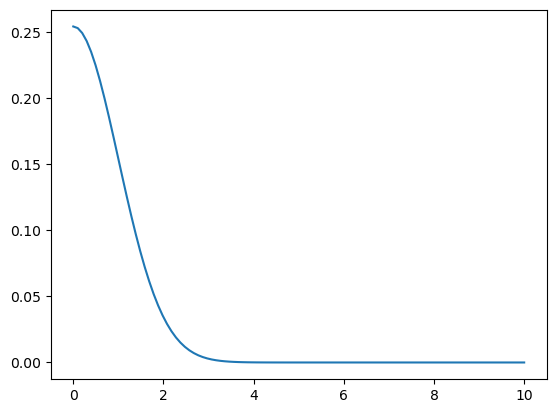

In [116]:
psi = result[1][:,0].reshape(solver.shape)
plt.figure()
plt.plot(solver.r0, solver.G_neumann @ psi[:,0].real)
plt.show()


In [111]:
H_solver = solver.T_m[0] + solver.V_m[0]
ic(H_solver.shape)


ic| H_solver.shape: (100, 100)


(100, 100)